# Coursework 1
## Part 3. Detecting problematic modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [2]:
DATA_PATH = "./Data"

In [3]:
df_dict = {}

for file_ in os.listdir(DATA_PATH):
    df_dict[file_] = pd.read_csv(os.path.join(DATA_PATH, file_))
    
df_dict["progresses.csv"].columns = ["progress_id", "student_id", "course_id"]

df_dict["students.csv"].columns = ['id_', 'student_id', 'city', 'birthday']
df_dict["students.csv"]["birthday"] = pd.to_datetime(df_dict["students.csv"]["birthday"], errors="coerce")

df_dict["courses.csv"].columns = ["index", "course_id", "course_title", "course_field"]
df_dict["courses.csv"].set_index("index", inplace=True)

dataset = pd.merge(left=df_dict["progresses.csv"],
                   right=df_dict["progress_phases.csv"],
                   on="progress_id",
                   how="outer")

dataset = pd.merge(left=dataset,
                   right=df_dict["courses.csv"],
                   on="course_id",
                   how="outer")

dataset = pd.merge(left=dataset,
                   right=df_dict["course_contents.csv"],
                   on=["course_id", "lesson_number", "module_number"],
                   how="outer")

dataset["start_date"] = (
    pd.to_datetime(dataset["start_date"], errors="coerce", utc=False)
    .dt.tz_localize(None)
    )

dataset["finish_date"] = (
    pd.to_datetime(dataset["finish_date"], errors="coerce", utc=False)
    .dt.tz_localize(None)
    )

dset_students = df_dict["students.csv"].copy(deep=True)
dset_students["age_years"] = (np.datetime64(str(2022)) - dset_students["birthday"]).astype("timedelta64[Y]")
#dset_students["student_age"] = dset_students["student_age"].astype("timedelta64[Y]")

print("Main dataset:", dataset.dtypes, dataset.columns, sep="\n", end="\n\n")
print("Student dataset:", dset_students.dtypes, dset_students.columns, sep="\n")

Main dataset:
progress_id              object
student_id               object
course_id                object
module_number           float64
lesson_number           float64
status                   object
start_date       datetime64[ns]
finish_date      datetime64[ns]
course_title             object
course_field             object
module_title             object
lesson_title             object
lesson_token             object
is_video                 object
is_homework              object
dtype: object
Index(['progress_id', 'student_id', 'course_id', 'module_number',
       'lesson_number', 'status', 'start_date', 'finish_date', 'course_title',
       'course_field', 'module_title', 'lesson_title', 'lesson_token',
       'is_video', 'is_homework'],
      dtype='object')

Student dataset:
id_                    int64
student_id            object
city                  object
birthday      datetime64[ns]
age_years            float64
dtype: object
Index(['id_', 'student_id', 'city', 'birth

### Questions

* how many unfinished modules?
* duration of each lesson
* duration of spaces between lessons?
* total module duration divided by number of homeworks
* difference between mean and median time

### Making a course-module id to avoid nested groupby
because module is being identified with just a number

by joining course_id and module_number

In [4]:
dataset["course-module_id"] = (
    dataset["course_id"] +
    "_" +
    dataset["module_number"].astype("str")
)

dataset["course-module_id"].sample(n=10)

199423     e9bb9205eeed307ee7cbaa08bfd166c3_4.0
198861     e9bb9205eeed307ee7cbaa08bfd166c3_2.0
261716    e3a0df907589d56692b5cb561fd90d87_12.0
322870     ccbab00e99b27f83369d6cc89d914ad6_1.0
215020     ac634845fb0350d0e9d49078aaa4b68f_4.0
77912     bf27a4bf4ada4c756451703ea62a914f_11.0
38451      bf27a4bf4ada4c756451703ea62a914f_3.0
70077      bf27a4bf4ada4c756451703ea62a914f_4.0
231183     c9fcb746d51e41bc5a217002d081454b_2.0
269902     e3a0df907589d56692b5cb561fd90d87_4.0
Name: course-module_id, dtype: object

How many unique modules?

In [5]:
dataset["course-module_id"].nunique()

230

### Time to complete module - data preparation

modules having 1 homework: 1 student = 1 progress ?

2 or more homeworks: 1 student = many progresses ?

progress / student ratio

In [6]:
temp_list = []

for module_id_, module_gr_ in dataset[dataset["is_homework"] == True].groupby("course-module_id"):
    
    if module_gr_["lesson_number"].nunique() > 1:
    
        temp_list.append(module_gr_["progress_id"].nunique() / module_gr_["student_id"].nunique())


pd.Series(temp_list)

0    1.0
1    1.0
2    1.0
3    1.0
4    1.0
5    1.0
6    1.0
7    1.0
dtype: float64

something's wrong

In [7]:
for module_id_, module_gr_ in dataset[dataset["is_homework"] == True].groupby("course-module_id"):
    
    if module_gr_["lesson_number"].nunique() > 1:
        
        print(dataset[dataset["course-module_id"] == module_id_]["course_title"].unique(),
              module_gr_["lesson_number"].unique(),
              module_id_)

['Java-разработчик c нуля'] [27. 21. 13. 17.  6. 25.] 943306102e5b067d08a29094f37b8193_4.0
['Java-разработчик c нуля'] [ 7. 13. 11.  5.  9.] 943306102e5b067d08a29094f37b8193_5.0
['Java-разработчик c нуля'] [13.  4.  6.  2.] 943306102e5b067d08a29094f37b8193_6.0
['Java-разработчик c нуля'] [8. 2.] 943306102e5b067d08a29094f37b8193_7.0
['Java-разработчик c нуля'] [ 8.  4. 11.] 943306102e5b067d08a29094f37b8193_8.0
['Java-разработчик c нуля'] [ 5.  7.  9. 12. 14.] 943306102e5b067d08a29094f37b8193_9.0
['Веб-дизайн PRO 2.0'] [3. 5.] c9fcb746d51e41bc5a217002d081454b_4.0
['UX-дизайн'] [7. 8.] dad6f6ffc086caa89e2f40c28a9c7490_9.0


Вопрос: найти общие для уроков одного модуля student_id

In [8]:
check = dataset[
    (dataset["is_homework"] == True) &
    (dataset["course-module_id"] == "943306102e5b067d08a29094f37b8193_4.0")].groupby("lesson_number")

check.count()

,progress_id,student_id,course_id,module_number,status,start_date,finish_date,course_title,course_field,module_title,lesson_title,lesson_token,is_video,is_homework,course-module_id
lesson_number,,,,,,,,,,,,,,,
6.0,162,162,162,162,162,162,151,162,162,162,162,162,162,162,162
13.0,147,147,147,147,147,147,142,147,147,147,147,147,147,147,147
17.0,141,141,141,141,141,141,131,141,141,141,141,141,141,141,141
21.0,133,133,133,133,133,133,122,133,133,133,133,133,133,133,133
25.0,126,126,126,126,126,126,113,126,126,126,126,126,126,126,126
27.0,115,115,115,115,115,115,110,115,115,115,115,115,115,115,115


number of students decreasing along hw completion in module

let's find a student, who did completed all homeworks in module - take one from the last group (27 lesson)

In [9]:
check.get_group(list(check.groups)[-1]).head(1)

,progress_id,student_id,course_id,module_number,lesson_number,status,start_date,finish_date,course_title,course_field,module_title,lesson_title,lesson_token,is_video,is_homework,course-module_id
334902,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,27.0,done,2019-04-11 10:56:03.684644,2019-04-14 03:12:23.012366,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.6,ed373787-d237-4fb3-8248-82595b0dde56,False,True,943306102e5b067d08a29094f37b8193_4.0


In [10]:
dataset[
    (dataset["student_id"] == "47c3c0e20c441a4fa021ca4bd8044e27") & 
    (dataset["is_homework"] == True) & 
    (dataset["course-module_id"] == "943306102e5b067d08a29094f37b8193_4.0")
]

,progress_id,student_id,course_id,module_number,lesson_number,status,start_date,finish_date,course_title,course_field,module_title,lesson_title,lesson_token,is_video,is_homework,course-module_id
334902,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,27.0,done,2019-04-11 10:56:03.684644,2019-04-14 03:12:23.012366,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.6,ed373787-d237-4fb3-8248-82595b0dde56,False,True,943306102e5b067d08a29094f37b8193_4.0
335494,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,21.0,done,2019-04-10 10:10:39.013230,2019-04-11 07:12:20.545344,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.4,e817fd9a-5417-42fa-b7c7-5eb4b073a4c5,False,True,943306102e5b067d08a29094f37b8193_4.0
336535,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,13.0,done,2019-04-08 11:21:12.288867,2019-04-09 12:48:04.289564,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.2,3979e3be-0215-4752-881b-0580bc6d2e0f,False,True,943306102e5b067d08a29094f37b8193_4.0
337489,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,17.0,done,2019-04-10 09:53:14.194003,2019-04-11 07:08:48.389104,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.3,6179c00f-24d9-438b-a2c8-063e6974eb79,False,True,943306102e5b067d08a29094f37b8193_4.0
339267,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,6.0,done,2019-04-08 09:55:35.476712,2019-04-09 12:08:28.996480,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.1,69816d53-c480-44cf-9fd1-3f4ec66a71c3,False,True,943306102e5b067d08a29094f37b8193_4.0
339981,d0cecd82f603e457eb1142def0fa3104,47c3c0e20c441a4fa021ca4bd8044e27,943306102e5b067d08a29094f37b8193,4.0,25.0,done,2019-04-11 10:12:13.605879,2019-04-13 12:40:59.080275,Java-разработчик c нуля,Development,"Числа, строки и даты",Домашняя работа 4.5,cd9b006e-25ac-424d-b33c-5f1e56190172,False,True,943306102e5b067d08a29094f37b8193_4.0


Вывод: прогресс считается общим для модуля (!придумать лучшее описание)

Lessons in module completed by one student share common progress_id

Need to just group by course-module_id and then by progress_id

In [11]:
temp_list = []

for module_id_, module_gr_ in dataset[dataset["is_homework"] == True].groupby("course-module_id"):
    
    min_series = module_gr_.groupby("progress_id")["start_date"].min()
    max_series = module_gr_.groupby("progress_id")["finish_date"].max()
    duration_series = max_series - min_series
    temp_list.append(
        [
        module_gr_["course_title"].iloc[0],
        module_gr_["module_title"].iloc[0],
        duration_series.mean(),
        duration_series.median(),
        duration_series.min(),
        duration_series.max()
        ]
    )

ds_completion = pd.DataFrame(temp_list, columns=["course_title", "module_title", "mean", "median", "min", "max"])
ds_completion

/home/iamcomputer/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,course_title,module_title,mean,median,min,max
0,Анимация интерфейсов,"Введение в Motion Design. Тренды, разновидност...",11 days 19:41:17.659012238,1 days 22:31:56.639415,0 days 00:00:00.003280,259 days 17:55:40.949636
1,Анимация интерфейсов,Principle (обновлён 06.06.19),13 days 09:09:49.877145857,6 days 01:01:22.889799500,0 days 00:00:00.002562,98 days 03:34:15.757248
2,Анимация интерфейсов,Webflow — инструмент прототипирования веб-инте...,26 days 07:41:06.099055629,12 days 23:33:59.876374,0 days 00:00:00.002737,124 days 13:29:23.789718
3,Анимация интерфейсов,InVision Studio,NaT,NaT,NaT,NaT
4,Анимация интерфейсов,Анимация статичной концепции,24 days 15:00:26.129520963,9 days 17:02:13.213271,0 days 00:00:00.003581,307 days 11:49:58.808785
...,...,...,...,...,...,...
186,JavaScript с нуля,Замыкания,17 days 10:51:14.284782233,10 days 00:24:29.275534,-1 days +23:59:59.999766,131 days 21:56:15.508538
187,JavaScript с нуля,Объекты и конструкторы,16 days 07:50:56.554498042,8 days 13:22:11.486400,-1 days +23:59:59.999763,256 days 18:41:38.869809
188,JavaScript с нуля,Объектно-ориентированное программирование,20 days 16:23:08.435682183,11 days 05:01:06.596879,-1 days +23:59:59.999762,175 days 18:34:19.222360
189,JavaScript с нуля,Разное,14 days 09:55:40.627778645,5 days 20:00:10.100321,-1 days +23:59:59.999607,200 days 12:22:43.394944


### Let's explore modules with NaTs

In [12]:
ds_completion[
    (ds_completion["mean"].isna() == True) |
    (ds_completion["median"].isna() == True) |
    (ds_completion["min"].isna() == True) |
    (ds_completion["max"].isna() == True)
]

,course_title,module_title,mean,median,min,max
3,Анимация интерфейсов,InVision Studio,NaT,NaT,NaT,NaT


*!conclusion about the module*

### When progress duration is too short

In [13]:
ds_completion[ds_completion["min"] > pd.Timedelta(1, "s")].shape

(33, 6)

Construct a new data frame where min value has to be greater than 1 second

In [16]:
temp_list = []

for module_id_, module_gr_ in dataset[dataset["is_homework"] == True].groupby("course-module_id"):
    
    groupby_progress = module_gr_.groupby("progress_id")
    start_series = groupby_progress["start_date"].min()
    end_series = groupby_progress["finish_date"].max()
    duration_series = end_series - start_series
    
    temp_list.append(
        [
        module_gr_["course_title"].iloc[0],
        module_gr_["module_title"].iloc[0],
        duration_series.mean(),
        duration_series.median(),
        duration_series[duration_series > pd.Timedelta(1, "s")].min(),
        duration_series.max(),
        module_gr_["course-module_id"].iloc[0]
        ]
    )


ds_completion2 = pd.DataFrame(temp_list, columns=["course_title", "module_title",
                                                  "mean", "median", "min", "max",
                                                  "course-module_id"])
ds_completion2.sample(n=5)

/home/iamcomputer/anaconda3/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1117: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


,course_title,module_title,mean,median,min,max,course-module_id
169,Веб-дизайн с нуля 2.0,"Тренды, подготовка, мудборды",11 days 18:58:19.828774756,6 days 00:32:48.015840,0 days 03:05:47.503226,200 days 09:20:53.373118,e3a0df907589d56692b5cb561fd90d87_3.0
105,Excel Базовый,Визуализация данных Excel,9 days 22:12:41.585209175,4 days 14:49:23.608582500,0 days 03:08:28.416579,174 days 20:08:51.808309,ac634845fb0350d0e9d49078aaa4b68f_7.0
7,Анимация интерфейсов,Чистая магия — cоздание продающего шоурила,29 days 10:53:38.126452412,22 days 23:30:45.667976,1 days 01:15:51.290740,107 days 08:05:12.483346,04ba6d0b40670c43a209141fa01fa784_18.0
26,Руководитель digital-проектов,Как пасти котов: правильное делегирование в IT,17 days 12:39:05.761461758,5 days 21:34:50.810553,0 days 01:30:13.730582,402 days 17:23:54.159575,0770b1b039964228294f1f34b29fc2c1_5.0
67,Java-разработчик,Синтаксис языка,17 days 18:31:13.299444999,7 days 04:49:57.747879,0 days 00:00:07.550920,377 days 14:05:09.720352,6e4837f0a65c68efbfdd0594d6774701_2.0


### Median course completion time plot

In [105]:
gr_by_course = ds_completion2[
    ["course_title", "module_title", "course-module_id", "median"]
].groupby("course_title")

# example
gr_by_course.get_group(list(gr_by_course["median"].groups)[0])

,course_title,module_title,course-module_id,median
99,Excel Базовый,Основной функционал Excel,ac634845fb0350d0e9d49078aaa4b68f_1.0,2 days 07:24:50.049678
100,Excel Базовый,Основной функционал Excel (продолжение),ac634845fb0350d0e9d49078aaa4b68f_2.0,1 days 20:24:06.134843500
101,Excel Базовый,Формулы и функции Excel. Введение,ac634845fb0350d0e9d49078aaa4b68f_3.0,1 days 11:54:27.957196
102,Excel Базовый,Формулы и функции Excel. Продолжаем работать с...,ac634845fb0350d0e9d49078aaa4b68f_4.0,3 days 04:58:46.128977
103,Excel Базовый,Формулы и функции Excel. Более сложные формулы,ac634845fb0350d0e9d49078aaa4b68f_5.0,2 days 23:30:55.474674500
104,Excel Базовый,"Формулы и функции Excel. Работа с ошибками, пр...",ac634845fb0350d0e9d49078aaa4b68f_6.0,2 days 09:01:55.077320
105,Excel Базовый,Визуализация данных Excel,ac634845fb0350d0e9d49078aaa4b68f_7.0,4 days 14:49:23.608582500
106,Excel Базовый,Сводные таблицы Excel,ac634845fb0350d0e9d49078aaa4b68f_8.0,2 days 21:33:42.186444
107,Excel Базовый,Экзаменационная работа,ac634845fb0350d0e9d49078aaa4b68f_9.0,10 days 04:44:47.225865


In [95]:
# extract module number expression example
[
    num[33:-2]
    for num in gr_by_course["course-module_id"].get_group(
            list(gr_by_course["course-module_id"].groups)[1]
        ).values
]

['1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '17',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9']

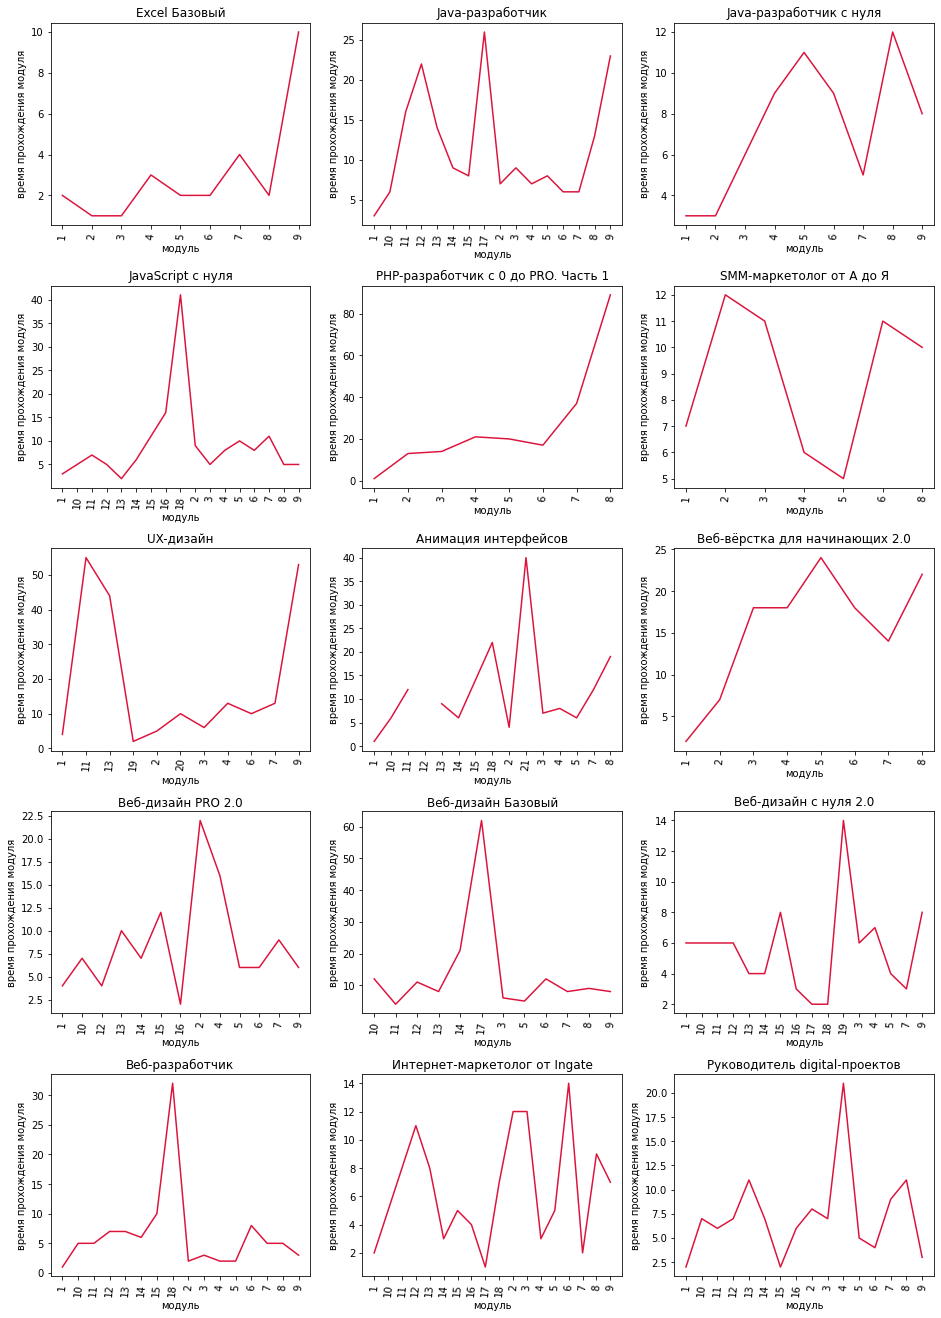

In [103]:
fig, axs = plt.subplots(5, 3, figsize=(13, 18))

fig.tight_layout()
fig.subplots_adjust(hspace=.3, wspace=0.2)

gr_index = 0
gr_names = gr_by_course["median"].groups # dict

for ax_row in axs:
    for ax in ax_row:
        
        plot_points = gr_by_course["median"].get_group(
            list(gr_by_course["median"].groups)[gr_index]
        ).astype("timedelta64[D]")
        
        plot_title = list(gr_by_course["median"].groups.keys())[gr_index]
        
        xtick_labels = [
            num[33:-2]
            for num in gr_by_course["course-module_id"].get_group(
                    list(gr_by_course["course-module_id"].groups)[gr_index]
                ).values
        ]
        
        ax.plot(plot_points, color="crimson")
        ax.tick_params(axis="x", labelrotation=85.0)
        ax.set_xticks(plot_points.index)
        ax.set_xticklabels(xtick_labels)
        ax.set_title(plot_title)
        ax.set_xlabel("модуль")
        ax.set_ylabel("время прохождения модуля")
        
        gr_index += 1
        

plt.show()